# Electroprophet⚡️

In this notebook, I will do the first steps on our final project for Le Wagon's Data Science bootcamp. Here, I'll try to model the carbon emission in France using weather data, in order to provide recomendations for users to reduce their carbon footprint 👣.

## Getting the data (outdated, don't use it)

In [1]:
%load_ext autoreload
%autoreload 2

### 1. Wheater API

Here we'll be able to get weather data of a chosen city. 

As the energy data is given by region, later we'll have to check how many cities we have to take in consideration in order to get the weather in a given region.

In [2]:
import requests
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import os.path

# Get the absolute path of the directory where the script is located
script_dir = os.getcwd()

# Construct the path to the "my_directory" directory relative to the script directory
raw_data_path = os.path.join(script_dir, "raw_data")

In [3]:
def get_weather(city, years=10, overwrite=False):
    
    '''
    This function receives the name of a city and a number of years, and returns a dataframe 
    with weather data from this city during those past years
    '''
    
    path = raw_data_path + '/df_' + city.lower() + '_weather.csv'
    file_exists = os.path.isfile(path) 
    
    if file_exists and not overwrite:
        
        print('Found a file for this city. Importing...')
        
        weather_df = pd.read_csv(path, index_col=0)
        
    else:
        
        print('Creating a new .csv file for this city')
        
        # First we declare the weather parameters. Here we'll be taking all params supported by the API
        weather_params = ['temperature_2m','relativehumidity_2m','dewpoint_2m',
                      'apparent_temperature','pressure_msl','surface_pressure',
                      'precipitation','rain','snowfall','cloudcover',
                      'cloudcover_low','cloudcover_mid','cloudcover_high',
                      'shortwave_radiation','direct_radiation','direct_normal_irradiance',
                      'diffuse_radiation','windspeed_10m','windspeed_100m',
                      'winddirection_10m','winddirection_100m','windgusts_10m',
                      'et0_fao_evapotranspiration','weathercode','vapor_pressure_deficit',
                      'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm',
                      'soil_temperature_28_to_100cm','soil_temperature_100_to_255cm',
                      'soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                      'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm']

        # This request is done in order to get the latitude and longitude of the desired city
        city_response = requests.get('https://geocoding-api.open-meteo.com/v1/search',
                           params = {'name': city}).json()

        lat = city_response['results'][0]['latitude']
        lon = city_response['results'][0]['longitude']

        # Then we compute the dates used to get the weather data
        ## The API only has data until 9 days ago
        end_date = (datetime.date.today() - relativedelta(days=8)).strftime('%Y-%m-%d') 
        #start_date = (datetime.date.today() - relativedelta(years=years)).strftime('%Y-%m-%d')
        start_date = '2013-01-01'

        # So we make the request to the weather API archive
        weather_response = requests.get('https://archive-api.open-meteo.com/v1/archive',
                           params = {'latitude': lat,
                                    'longitude': lon,
                                    'start_date': start_date,
                                    'end_date': end_date,
                                    'hourly': weather_params,
                                    'timezone': 'auto'}).json()
        
        weather_df = pd.DataFrame(weather_response['hourly'], columns = ['time'] + weather_params)
        weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%d')
        weather_df = weather_df.set_index('time')
        
        weather_df.to_csv(path)
    
    print('Done ✅')
    return weather_df

In [4]:
from prophecy import data

data.get_weather('Amiens')
#df = data.get_weather('Paris',overwrite=True)
#df = data.get_weather('Marseille',overwrite=True)

ImportError: cannot import name 'data' from 'prophecy' (/home/jupyter/code/caiovnd/electroprophet/prophecy/__init__.py)

In [ ]:
import pandas as pd
pd.to_datetime(df.index, format='%Y-%m-%d')

In [ ]:
import datetime

print(datetime.datetime.strptime('2013-01-01','%Y-%m-%d'))

First let's explore and see if we find any problems

In [ ]:
df.duplicated().sum() # Checking for duplicates

In [ ]:
df.isnull().sum().sort_values(ascending=False)/len(df) # Checking for null values

In [ ]:
weather_params = ['temperature_2m','relativehumidity_2m','dewpoint_2m',
                      'apparent_temperature','pressure_msl','surface_pressure',
                      'precipitation','rain','snowfall','cloudcover',
                      'cloudcover_low','cloudcover_mid','cloudcover_high',
                      'shortwave_radiation','direct_radiation','direct_normal_irradiance',
                      'diffuse_radiation','windspeed_10m','windspeed_100m',
                      'winddirection_10m','winddirection_100m','windgusts_10m',
                      'et0_fao_evapotranspiration','weathercode','vapor_pressure_deficit',
                      'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm',
                      'soil_temperature_28_to_100cm','soil_temperature_100_to_255cm',
                      'soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                      'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Then we can preprocess our data

### 1. MinMax Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
df_preproc = df.copy()
for feature in weather_params:
    scaler.fit(df[[feature]])
    df_preproc[feature] = scaler.transform(df[[feature]])

In [ ]:
df_preproc.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

index = 0

for index in enumerate(weather_params):
    index=index[0]
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))

    sns.histplot(df[weather_params[index]], bins=200,kde = True, ax=axes[0]);
    sns.boxplot(data=df, x=weather_params[index], ax=axes[1]);
    sns.histplot(df_preproc[weather_params[index]], bins=200,kde = True, ax=axes[2], color='orange');
    sns.boxplot(data=df_preproc, x=weather_params[index], ax=axes[3], color='orange');

### 2. Robust Scaler

In [ ]:
from sklearn.preprocessing import RobustScaler


rb_scaler = RobustScaler() 
df_preproc2 = df.copy()
for feature in weather_params:
    rb_scaler.fit(df[[feature]])
    df_preproc2[feature] = rb_scaler.transform(df[[feature]])

rb_scaler.fit(data[['GrLivArea']]) 

data['GrLivArea'] = rb_scaler.transform(data[['GrLivArea']]) 


In [ ]:
df_weather = data.get_weather('Amiens')
df_weather

In [ ]:
df_merge = data.merge_weather_energy_df('Amiens', 'Hauts-de-France', 'eolien')
df_merge

In [ ]:
prod_df = data.get_energy_production(-1, 0, 'Hauts-de-France')

In [ ]:
prod_df.columns

## Baseline model - Random Forest (not the best parameters)

First we import our class:

In [ ]:
from prophecy.data_3_cities import WeatherEnergy

In [5]:
data = WeatherEnergy(limit=-1, offset=0, refine='Hauts-de-France', city1='Heudicourt', city2='Bucy-les-Pierrepont', city3='Riencourt', target='eolien')

NameError: name 'WeatherEnergy' is not defined

Then we get our dataframe

In [ ]:
df = data.merged()
df.head()

And we drop all `NaN`'s from our target

In [ ]:
df_nona=df.dropna(subset=['eolien'])

Now we define our features and target

In [ ]:
X = df_nona.drop(columns=['eolien','weathercode'])
y = df_nona['eolien']

Then we run and evaluate our baseline model with RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
forest = RandomForestRegressor(max_depth=10, n_estimators=100)
score_baseline = cross_val_score(forest, X, y, cv=5,scoring='r2',n_jobs=-1)
score_baseline.mean()

Let's try also for XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)
score_baseline = cross_val_score(xgb_reg, X, y, cv=5,scoring='r2',n_jobs=-1)
score_baseline.mean()

## Model Tuning - Random Forest (here I run GridSearch and use the best parameters)

In [ ]:
import numpy as np
import pandas as pd
from random import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import multiprocessing

In [ ]:
df_scaled = pd.read_csv('raw_data/wind_energy_scaled.csv',index_col=0)
df_scaled.head()

In [ ]:
df_scaled.columns

In [ ]:
X_scaled = df_scaled.drop(columns=['eolien'])
y = df_scaled['eolien']

In [ ]:
X_red = X_scaled.tail(8760)
y_red = y.tail(8760)

In [ ]:
forest = RandomForestRegressor(max_depth=10, n_estimators=100)
score_scaled = cross_val_score(forest, X_red, y_red, cv=5,scoring='r2',n_jobs=-1)
score_scaled.mean()

In [ ]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

In [ ]:
# Use RandomizedSearchCV to search for the best hyperparameters
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=multiprocessing.cpu_count(), scoring='r2')

In [ ]:
# Fit the model on the Boston Housing dataset
random_search.fit(X_red, y_red)

In [ ]:
# Print the best hyperparameters found
print('Best hyperparameters:', random_search.best_params_)

Results from last run: (n_estimators: 150, min_samples_split: 2, min_samples_leaf: 2, max_depth: 10)

In [ ]:
# Print the best score found
print('Best score:', random_search.best_score_)

## Feature importance

In [186]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.inspection import permutation_importance

Here I use the .csv without the vector features

In [187]:
df_scaled = pd.read_csv('raw_data/wind_energy_scaled.csv',index_col=0)

Here I am dropping the worst features

In [188]:
X_scaled = df_scaled.drop(columns=['eolien','cloudcover','cloudcover_low','cloudcover_mid',
                       'cloudcover_high','shortwave_radiation','direct_radiation',
                      'direct_normal_irradiance','diffuse_radiation','et0_fao_evapotranspiration',
                       'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm','soil_temperature_28_to_100cm',
                       'soil_temperature_100_to_255cm','soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                       'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm','dewpoint_2m','precipitation',
                        'rain','snowfall'])
y = df_scaled['eolien']

In [189]:
X_red_train = X_scaled.iloc[:8760]
y_red_train = y.iloc[:8760]
X_red_test = X_scaled.iloc[8760:8784]
y_red_test = y.iloc[8760:8784]

In [190]:
forest = RandomForestRegressor(n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_depth=10)
result = forest.fit(X_red_train,y_red_train)

In [191]:
result = permutation_importance(forest, X_red_test, y_red_test.values, n_repeats=10, random_state=42, scoring='r2')

In [197]:
df = pd.DataFrame({
    'feature': X_red_test.columns,
    'importance_mean': abs(result['importances_mean']),
    'importance_std': result['importances_std']
}).sort_values('importance_mean', ascending=False)

print(df)

                   feature  importance_mean  importance_std
6           windspeed_100m         0.755956        0.197437
8       winddirection_100m         0.160437        0.059801
5            windspeed_10m         0.046652        0.021766
7        winddirection_10m         0.027003        0.017087
9            windgusts_10m         0.017687        0.013001
3             pressure_msl         0.008122        0.018070
2     apparent_temperature         0.006556        0.016101
1      relativehumidity_2m         0.005053        0.010814
10  vapor_pressure_deficit         0.004954        0.011637
0           temperature_2m         0.002770        0.006516
4         surface_pressure         0.001269        0.004982


## Best RandomForest

In [200]:
df_scaled = pd.read_csv('raw_data/wind_energy_scaled.csv',index_col=0)

In [201]:
X_scaled = df_scaled.drop(columns=['eolien','cloudcover','cloudcover_low','cloudcover_mid',
                       'cloudcover_high','shortwave_radiation','direct_radiation',
                      'direct_normal_irradiance','diffuse_radiation','et0_fao_evapotranspiration',
                       'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm','soil_temperature_28_to_100cm',
                       'soil_temperature_100_to_255cm','soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                       'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm','dewpoint_2m','precipitation',
                        'rain','snowfall'])
y = df_scaled['eolien']

Training one year to predict the following day

In [202]:
X_red_train = X_scaled.iloc[:8760]
y_red_train = y.iloc[:8760]
X_red_test = X_scaled.iloc[8760:8784]
y_red_test = y.iloc[8760:8784]

Using the best params from GridSearch

In [203]:
forest = RandomForestRegressor(n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_depth=10)
score_scaled = cross_val_score(forest, X_red_train, y_red_train, cv=5,scoring='r2',n_jobs=-1)
score_scaled.mean()

0.7430569325747344

## SARIMAX (gave up on it)

In [12]:
from pmdarima.arima import auto_arima
import statsmodels.api as sm
import numpy as np
import pandas as pd
from random import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import multiprocessing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
df_scaled = pd.read_csv('raw_data/wind_energy_scaled.csv',index_col=0)

In [8]:
X_scaled = df_scaled.drop(columns=['eolien','cloudcover','cloudcover_low','cloudcover_mid',
                       'cloudcover_high','shortwave_radiation','direct_radiation',
                      'direct_normal_irradiance','diffuse_radiation','et0_fao_evapotranspiration',
                       'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm','soil_temperature_28_to_100cm',
                       'soil_temperature_100_to_255cm','soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
                       'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm','dewpoint_2m','precipitation',
                        'rain','snowfall'])
y = df_scaled['eolien']

In [9]:
X_red_train = X_scaled.iloc[:8760]
y_red_train = y.iloc[:8760]
X_red_test = X_scaled.iloc[8760:8784]
y_red_test = y.iloc[8760:8784]

In [22]:
# Define the SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(endog=y_red_train, exog=X_red_train, order=(2,1,1), seasonal_order=(1,0,0,12))

# Use auto_arima to find the best hyperparameters for the SARIMAX model
arima_model = auto_arima(y_red_train, exogenous=X_red_train, seasonal=True, m=24, 
                         max_p=2, max_d=2, max_q=2, max_P=2, max_D=1, max_Q=2, 
                         stepwise=False, trace=True, information_criterion='bic',
                         parallel=True,njobs=-1)

# Print the best hyperparameters found by auto_arima
print(arima_model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[24] intercept   : BIC=98027.042, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : BIC=98020.789, Time=6.33 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : BIC=98008.724, Time=50.05 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : BIC=98019.217, Time=6.05 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : BIC=inf, Time=27.84 sec
 ARIMA(0,1,0)(1,0,2)[24] intercept   : BIC=inf, Time=105.43 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : BIC=98004.034, Time=23.20 sec
 ARIMA(0,1,0)(2,0,1)[24] intercept   : BIC=inf, Time=107.49 sec
 ARIMA(0,1,0)(2,0,2)[24] intercept   : BIC=inf, Time=88.94 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : BIC=95529.799, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : BIC=95530.782, Time=15.86 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : BIC=95532.080, Time=57.50 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : BIC=95530.278, Time=13.71 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : BIC=inf, Time=35.89 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : BIC=inf, Time=120.15 sec
 A

KeyboardInterrupt: 

In [23]:
# Fit the SARIMAX model using the best hyperparameters found by auto_arima
sarima = SARIMAX(endog=y_red_train, exog=X_red_train, order=(0, 1, 2), seasonal_order=(0, 0, 0, 24))
results = sarima.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.41709D+00    |proj g|=  7.89079D-03


 This problem is unconstrained.



At iterate    5    f=  5.41703D+00    |proj g|=  4.50209D-03

At iterate   10    f=  5.41436D+00    |proj g|=  5.04472D-02

At iterate   15    f=  5.40673D+00    |proj g|=  3.24935D-04

At iterate   20    f=  5.40607D+00    |proj g|=  5.29064D-04

At iterate   25    f=  5.40576D+00    |proj g|=  5.77823D-03

At iterate   30    f=  5.40535D+00    |proj g|=  1.61018D-04

At iterate   35    f=  5.40530D+00    |proj g|=  3.30801D-03

At iterate   40    f=  5.40376D+00    |proj g|=  1.69271D-02

At iterate   45    f=  5.40343D+00    |proj g|=  3.51815D-04


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  5.40328D+00    |proj g|=  7.49188D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   7.492D-05   5.403D+00
  F =   5.4032758341898148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [24]:
y_red_test

time
2014-03-13 00:00:00    130.0
2014-03-13 01:00:00     88.0
2014-03-13 02:00:00     59.0
2014-03-13 03:00:00     38.0
2014-03-13 04:00:00     31.0
2014-03-13 05:00:00     24.0
2014-03-13 06:00:00     25.0
2014-03-13 07:00:00     27.0
2014-03-13 08:00:00     23.0
2014-03-13 09:00:00     21.0
2014-03-13 10:00:00     11.0
2014-03-13 11:00:00      5.0
2014-03-13 12:00:00      4.0
2014-03-13 13:00:00      5.0
2014-03-13 14:00:00      3.0
2014-03-13 15:00:00      4.0
2014-03-13 16:00:00      3.0
2014-03-13 17:00:00      5.0
2014-03-13 18:00:00     20.0
2014-03-13 19:00:00     71.0
2014-03-13 20:00:00    119.0
2014-03-13 21:00:00    169.0
2014-03-13 22:00:00    195.0
2014-03-13 23:00:00    222.0
Name: eolien, dtype: float64

In [25]:
# Make predictions on the test data using the trained model
predictions = results.predict(start='2014-03-13 00:00:00', end='2014-03-13 23:00:00', exog=X_red_test)
predictions

2014-03-13 00:00:00    160.696759
2014-03-13 01:00:00    144.410051
2014-03-13 02:00:00    138.373236
2014-03-13 03:00:00    132.478550
2014-03-13 04:00:00    124.619753
2014-03-13 05:00:00    115.290466
2014-03-13 06:00:00    105.847554
2014-03-13 07:00:00    104.838611
2014-03-13 08:00:00     92.250412
2014-03-13 09:00:00     80.913424
2014-03-13 10:00:00     69.113415
2014-03-13 11:00:00     60.237952
2014-03-13 12:00:00     65.731024
2014-03-13 13:00:00     73.038856
2014-03-13 14:00:00     87.111301
2014-03-13 15:00:00     91.460262
2014-03-13 16:00:00     94.227666
2014-03-13 17:00:00     93.047691
2014-03-13 18:00:00     73.071411
2014-03-13 19:00:00     58.845513
2014-03-13 20:00:00     84.390561
2014-03-13 21:00:00     99.473210
2014-03-13 22:00:00    125.658680
2014-03-13 23:00:00    159.982042
Freq: H, Name: predicted_mean, dtype: float64

In [26]:
from sklearn.metrics import r2_score

In [27]:
# Calculate the score of the forecast
score = r2_score(y_red_test, predictions)
print('Forecast score:', score)

Forecast score: -0.22568302482914215


Don't forget to move this notebook back to the notebooks folder using import sys

## RNN

### Importations

In [177]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

from typing import Dict, List, Tuple, Sequence

### Getting the dataframe

In [239]:
df_scaled = df = pd.read_csv('raw_data/wind_energy_1.csv',index_col=0)

### Defining global variables

In [240]:
# Let's define the global variables of our dataset
TARGET = 'eolien'
N_TARGETS = 1
N_FEATURES = df.shape[1] - 1

Defining the folds informations

In [241]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 24*365 * 3 # every hour
                        # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #
    
FOLD_STRIDE = 24*91 # every hour
                   # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66

And the input length

In [242]:
INPUT_LENGTH = 24 * 7 # records every hour
                      # one week

### Getting the folds

In [243]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """    
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    # $CHALLENGIFY_BEGIN
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [244]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 29 folds.
Each fold has a shape equal to (26280, 42).


In [245]:
fold = folds[0]
fold

,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,direct_normal_irradiance,diffuse_radiation,windgusts_10m,et0_fao_evapotranspiration,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,eolien,Wx_10,Wy_10,Wx_100,Wy_100,period_Afternoon,period_Morning,period_Night,weekday_Weekday,weekday_Weekend,season_Fall,season_Spring,season_Summer,season_Winter
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-03-15 00:00:00,-1.4,79.0,-4.6,-6.1,1017.1,1002.9,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2,0.00,0.12,1.1,2.0,4.3,5.7,0.375,0.373,0.381,0.383,36.0,2.872969,-7.893418,4.451322,-7.123604,0,0,1,1,0,0,0,0,1
2013-03-15 01:00:00,-1.7,81.0,-4.5,-6.5,1017.1,1002.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,0.00,0.10,0.9,1.9,4.3,5.7,0.374,0.373,0.381,0.383,72.0,1.389185,-7.878462,2.996853,-7.417471,0,0,1,1,0,0,0,0,1
2013-03-15 02:00:00,-4.1,87.0,-6.0,-6.8,1017.2,1002.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.5,0.00,0.06,0.8,1.9,4.3,5.7,0.374,0.373,0.381,0.383,119.0,-0.376819,-7.190133,1.002046,-7.129930,0,0,1,1,0,0,0,0,1
2013-03-15 03:00:00,-5.3,90.0,-6.7,-6.6,1016.9,1002.6,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.5,0.00,0.04,0.8,1.9,4.3,5.7,0.374,0.373,0.381,0.383,175.0,-2.224922,-6.847607,-0.251276,-7.195614,0,0,1,1,0,0,0,0,1
2013-03-15 04:00:00,-6.3,92.0,-7.3,-6.6,1016.6,1002.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.9,0.00,0.03,0.8,1.9,4.3,5.7,0.373,0.373,0.381,0.383,243.0,-3.550000,-6.148780,-1.597152,-6.918027,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-13 19:00:00,7.2,64.0,0.9,2.9,1029.1,1015.2,0.0,0.0,0.0,14.0,15.0,0.0,0.0,34.0,17.0,231.7,17.0,34.2,0.05,0.36,7.3,6.5,5.9,7.3,0.367,0.382,0.402,0.380,1154.0,12.871825,12.003171,12.225987,12.660380,1,0,0,0,1,0,0,0,1
2016-03-13 20:00:00,6.5,70.0,1.4,1.9,1029.5,1015.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.5,0.03,0.29,6.5,6.5,5.9,7.3,0.367,0.382,0.402,0.380,1260.0,14.045437,12.646568,13.129043,13.595522,0,0,1,0,1,0,0,0,1
2016-03-13 21:00:00,5.7,74.0,1.4,1.0,1029.6,1015.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.6,0.03,0.24,5.9,6.5,5.9,7.3,0.367,0.381,0.401,0.380,1375.0,13.647161,13.647161,12.661939,14.565895,0,0,1,0,1,0,0,0,1


### Spliting the train and test samples

In [246]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on 
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """
    # $CHALLENGIFY_BEGIN
    
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [247]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [248]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days = {int(INPUT_LENGTH/24/7)} weeks')

N_FEATURES = 41
INPUT_LENGTH = 168 timesteps = 7 days = 1 weeks


In [249]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


### Getting sequences

#### Random based

In [250]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired 
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be 
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    # $CHALLENGIFY_BEGIN
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [251]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [252]:
X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

#### Not random 

In [253]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> Tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences 
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    # $CHALLENGIFY_BEGIN    
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [254]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

In [255]:
SEQUENCE_STRIDE = 1

### Running the model

In [334]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [389]:
def init_model(X_train, y_train):
    
    # $CHALLENGIFY_BEGIN    
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=['mae'])
    
    return model
    # $CHALLENGIFY_END

In [390]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_57 (Normaliza  (None, None, 42)         85        
 tion)                                                           
                                                                 
 lstm_57 (LSTM)              (None, 64)                27392     
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 27,542
Trainable params: 27,457
Non-trainable params: 85
_________________________________________________________________


In [391]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    # $CHALLENGIFY_BEGIN
    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [392]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [393]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_58 (Normaliza  (None, None, 42)         85        
 tion)                                                           
                                                                 
 lstm_58 (LSTM)              (None, 64)                27392     
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 27,542
Trainable params: 27,457
Non-trainable params: 85
_________________________________________________________________
Epoch 1/50
146/146 [==============================] - 15s 87ms/step - loss: 270099.5625 - mae: 350.4124 - val_loss: 234111.4375 - val_mae: 318.2351
Epoch 2/50
146/146 [==============================] - 12s 84ms/step - loss: 196438.0781 - mae: 302

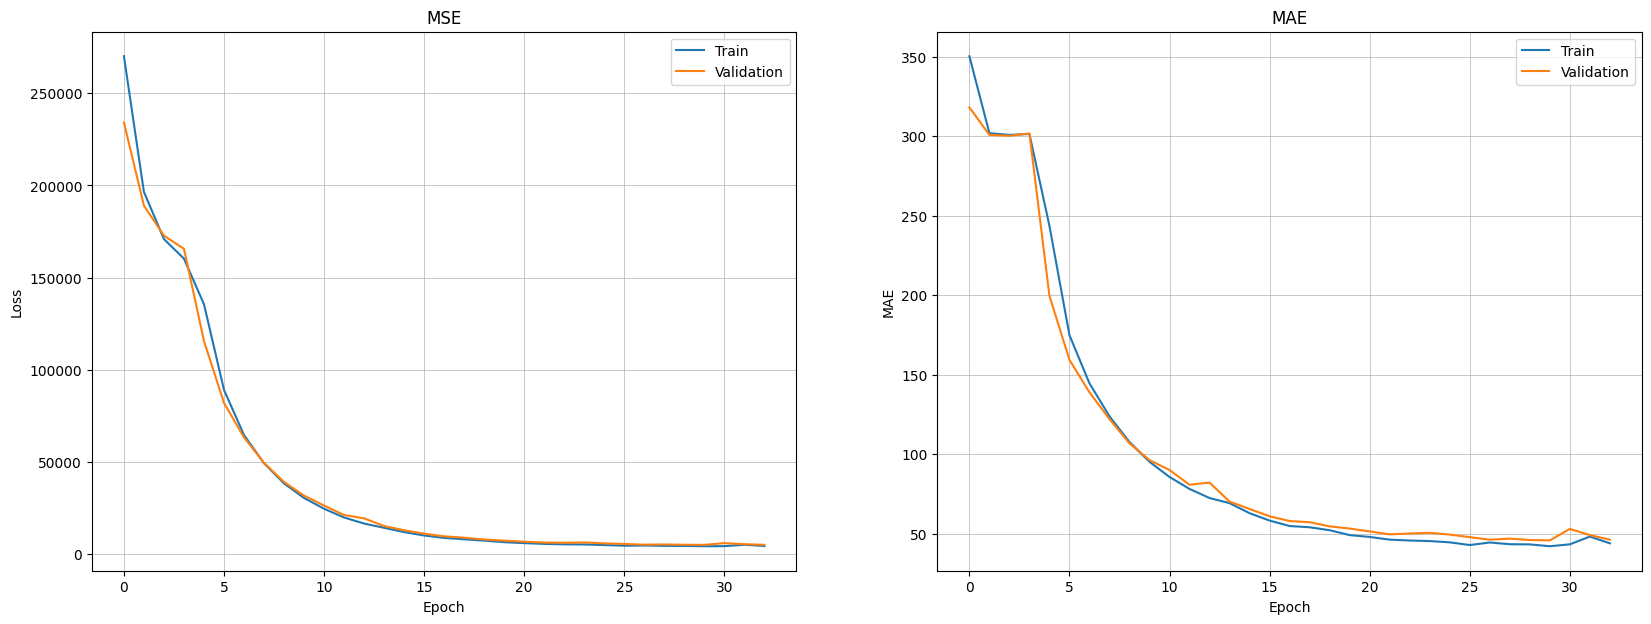

In [394]:
plot_history(history);

In [418]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [406]:
y_pred = model.predict(X_test)

105/105 [==============================] - 2s 23ms/step


In [508]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
model

In [424]:
import math

In [425]:
print('R2 Score: ', r2_score(y_test.reshape((3333,1)), y_pred))
print('MSE Score: ', mean_squared_error(y_test.reshape((3333,1)), y_pred))
print('MAE Score: ', mean_absolute_error(y_test.reshape((3333,1)), y_pred))
print('MAPS error: ', mean_absolute_percentage_error(y_test.reshape((3333,1)), y_pred))
print('RMSE Score: ', math.sqrt(mean_squared_error(y_test.reshape((3333,1)), y_pred)))

R2 Score:  0.941293687282395
MSE Score:  18460.38649782748
MAE Score:  82.30760294905376
MAPS error:  0.3038201253449536
RMSE Score:  135.8690049195455


### Cross-validation

In [ ]:
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)}")

In [ ]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    # $CHALLENGIFY_BEGIN
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model
    # $CHALLENGIFY_END

In [ ]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)}")

105/105 [==============================] - 0s 1ms/step - loss: 704092.9375 - mae: 623.7947
- The Baseline MAE on the test set is equal to 623.79


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
%%time
# WARNING : it takes 75 minutes to run this cell 
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

CPU times: user 20 µs, sys: 9 µs, total: 29 µs
Wall time: 34.8 µs


## Feature importance (RNN)

In [505]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, scoring='r2')

ValueError: Found array with dim 3. Estimator expected <= 2.

In [506]:
X_test.shape

(3333, 168, 42)

In [507]:
y_test.shape

(3333, 1, 1)